# Inhibition Model Notebook

Requirements:
- Python version 3.8.10
- Nest version 3.3

In [ ]:
import nest

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib import rcParams 
import os.path
import scipy as scp
from scipy.interpolate import interp1d
import time
import os

In [ ]:
folder_name = '/home/ubuntu/cosyne-tutorial-2022/inh_model_results/' # saving results to a folder
save = 1 # flag for saving results: 0 = off, 1 = save in folder: folder_name

# Functions

#### `create_spectro(tone)`
creates an entire spectrogram of time_sim length and 3500 frequency channels (same number as human IHCs population) the implemented spectrogram will present only a pure tone sound, stationary for the entire time_sim
if gauss_on = 1, 21 channels will be activated (by setting a non-zero amplitude value), centred on the channel corresponding to the pure tone (channel_x)
if gauss_on = 0, only channel_x will be activated with amplitude = 1

In [ ]:
def create_spectro(tone):
            
    channel_x = np.where(freq>=tone)[0][0]
    spectro = np.zeros((3500,time_sim))
    amplitudes = np.round(stats.norm.pdf(np.linspace(-1, 1, 21) , 0, 1.0/(math.sqrt(2*math.pi)*1)),2) #gaussian profile of amplitudes, with peak_amplitude = 1 for channel_x
    
    if(gauss_on):
        if(channel_x<10): #truncation of the gaussian profile of amplitudes
            spectro[channel_x:channel_x+10+1,:] = amplitudes[10:].reshape(11,1)*np.ones((11, time_sim))
            spectro[0:channel_x+1, :] = amplitudes[10-channel_x:11].reshape(channel_x+1,1)*np.ones((channel_x+1, time_sim))
        else:
            if(channel_x>3489): #truncation of the gaussian profile of amplitudes
                spectro[channel_x-10:channel_x+1] = amplitudes[:11].reshape(11,1)*np.ones((11, time_sim))
                spectro[channel_x:] = amplitudes[10:10+3500-channel_x].reshape(3500-channel_x,1)*np.ones((3500-channel_x, time_sim))
            else:
                spectro[channel_x - 10 : channel_x + 10 + 1, :] = amplitudes.reshape(21,1)*np.ones((21, time_sim))
    else:
        spectro[channel_x, :] = np.ones(time_sim)
        
    return spectro

#### `compute_ild_functions_ppg()`
computes the functions that return an ILD value according to an azimuth angle, by interpolating "ild_values", if PPG device are chosen

In [ ]:
def compute_ild_functions_ppg():
    x_values = np.array([-90,0,90])

    if(ild_on):
        y_values = ild_values
    else:
        y_values =  np.repeat(ild_values[1],3)

    r_function = interp1d(x_values, y_values, kind='linear')
    l_function = interp1d(x_values[::-1], y_values, kind='linear')
    
    """fig, ax = plt.subplots(1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(-100,100)
    ax.set_xlabel("Angles [°]")
    ax.set_ylabel("Spikes per Period")
    ax.set_xticks(np.linspace(-90,90,7))

    x = np.linspace(-90,90,181)
    ax.plot(x, r_function(x),  color = 'darkgreen', label = "Right Amplitude")
    ax.plot(x, l_function(x),  color = 'darkmagenta', label = "Left Amplitude")
    ax.axhline(y = ild_values[1], xmin = 0.05, xmax = 0.95, color = 'r', label = "Mean Rate")
    ax.legend()"""
        
    return(r_function,l_function)

#### `compute_ild_functions_spg()`
computes the functions that return an ILD value according to an azimuth angle, by interpolating "ild_rates", if SPG device are chosen

In [ ]:
def compute_ild_functions_spg():
    x_values = np.array([-90,0,90])

    if(ild_on):
        y_values = ild_rates
    else:
        y_values = np.repeat(ild_rates[1],3)


    def expfunc(x, a, b, c):
        return a + (b * np.exp(c * x))

    r_params, p_cov = scp.optimize.curve_fit(expfunc, x_values, ild_rates, bounds = ([-np.inf, 0, 0], [np.inf, np.inf, np.inf]))
    l_params, p_cov = scp.optimize.curve_fit(expfunc, x_values, ild_rates[::-1], bounds = ([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf]))
    
    """fig, ax = plt.subplots(1)
    ax.set_xlim(-100,100)
    ax.set_xlabel("Angles [°]")
    ax.set_ylabel("Firing Rate [Hz]")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(np.linspace(-90,90,7))
    x = np.linspace(-90,90,181)
    ax.plot(x, expfunc(x, *r_params),  color = 'darkgreen', label = "Right Amplitude")
    ax.plot(x,expfunc(x, *l_params), color = 'darkmagenta', label = "Left Amplitude")
    ax.axhline(y = ild_rates[1], xmin = 0.05, xmax = 0.95, color = 'r', label = "Mean Rate")
    ax.legend()"""

    return r_params,l_params

#### `compute_itd(angle)`
computes the value of ITD in milliseconds given the azimuth angle

In [ ]:
def compute_itd(angle):
    delta_x = (w_head*np.sin(np.deg2rad(angle)))
    itd = 1000*delta_x/v_sound #ms
    itd = np.round(itd,2) #only for spike_generators
    return itd

#### `ppg_set_up(spectro, ms)`
sets up the Pulse Packet Generators (PPGs) according to the spectrogram, the ITD and the ILD functions

In [ ]:
def ppg_set_up(spectro, ms):
    
    for r in range(0, len(spectro)-1):
        if spectro[r][ms] > 0:
            r_ANFs_amp[10*r:10*(r+1)].set(pulse_times = np.around(np.arange(1, time_sim+1, 1000/freq[r]),2))
            l_ANFs_amp[10*r:10*(r+1)].set(pulse_times = np.around(np.arange(1+itd, time_sim+itd+1, 1000/freq[r]),2))
            """print(freq[r], "Hz")
            print(ms, "ms")
            print(np.around(np.arange(1, time_sim+1, 1000/freq[r]),2))
            print(np.around(np.arange(1+itd, time_sim+itd+1, 1000/freq[r]),2))"""
            
            if ms in np.around(np.arange(0, time_sim, 1000/freq[r]), 0):
                r_ANFs_amp[10*r:10*(r+1)].set(activity = int(spectro[r][ms]*r_function(angle)))
                l_ANFs_amp[10*r:10*(r+1)].set(activity = int(spectro[r][ms]*l_function(angle)))
                """"print("------------------------------")
                print(int(spectro[r][ms]*r_num_spikes(angle)), "right activity")
                print(int(spectro[r][ms]*l_num_spikes(angle)), "left activity")
                print("------------------------------")"""
            #ANF_noise to parrots
            nest.Connect(ANFs_noise, r_ANFs[10*r:10*(r+1)], 'all_to_all')
            nest.Connect(ANFs_noise, l_ANFs[10*r:10*(r+1)], 'all_to_all')

#### `spg_set_up(spectro, ms)`
sets up the Sinusoidal Poisson Generators (SPGs) according to the spectrogram, the ITD and the ILD functions

In [ ]:
def spg_set_up(spectro, ms):
    
    def expfunc(x, a, b, c):
        return a + (b * np.exp(c * x))

    for r in range(0, len(spectro)-1):
        if spectro[r][ms] > 0:
            r_ANFs_amp[10*r:10*(r+1)].set(rate = ild_rates[1])
            l_ANFs_amp[10*r:10*(r+1)].set(rate = ild_rates[1])
            r_ANFs_amp[10*r:10*(r+1)].set(amplitude = spectro[r][ms]*expfunc(angle, *r_params))
            l_ANFs_amp[10*r:10*(r+1)].set(amplitude = spectro[r][ms]*expfunc(angle, *l_params))

            nest.Connect(ANFs_noise, r_ANFs[10*r:10*(r+1)], 'all_to_all')
            nest.Connect(ANFs_noise, l_ANFs[10*r:10*(r+1)], 'all_to_all')

# Network Variables

## General Variables

In [ ]:
tones = [100] # [Hz], sound frequency of the pure tones tested
angles = np.arange(-90,100,15) #[°], range of azimuth angles
time_sim = 1000 #[ms]
w_head = 22 #[cm]
v_sound = 33000 #[cm/s]

ANF_device = 'PPG' #PulsePacket Generator vs Sinsoidal Poisson Generator 'SPG'
ild_on = 1 #[flag] for simulation with ILDs or only with ITDs in input
gauss_on = 1 #[flag] for pure tones stimulation, inclusion of lateral freqeuncy channels (i.e, for 100 Hz pure tones, we activate 21 channels with characteristic frequency between 99 and 101 Hz, centred in 100 Hz)

ild_values = [10,50,100] #[nr. of spikes], num of spikes for each pulse packet (PPG parameter)
sdev = 0.1 #[ms] Standard Deviation in PPG spikes for each pulse-packet (PPG parameter)
ild_rates = [100,125,300] #[Hz], rates for SPG
noise_rate = 0 # [Hz], valid for both types

## Neuronal Populations Variables

In [ ]:
#Single cells
V_m = -70 #mV
V_reset = -70 #mV
c_scb = 1
c_gcb = 1
c_mso = 1
c_lso = 1 #pF

#MSO cells
delays_mso = [1,1.3,1,0.45,0.44] #ms

mso_neurons = [1,2,3,4]
taus_mat =  [[0.2, 0.1, 0.2, 0.01],
              [0.2, 0.1, 0.5, 0.1],
             [0.2, 0.1, 0.75, 0.14],
            [0.2, 0.1, 1.2, 0.18]]
#taus90 [0.2, 0.1, 1.2, 0.18] # #taus50: [0.2, 0.1, 0.75, 0.14] #taus30: [0.2, 0.1, 0.5, 0.1] , #taus15: [0.2, 0.1, 0.2, 0.01]

#Synaptic Weights
ANFs2SBCs_weight = 16
ANFs2GBCs_weight = 8
GBCs2MNTBCs_weight = 16.0
MNTBCs2LSO_weight = -2.0 
SBCs2LSO_weight = 8
SBCs2MSO_weight = 1
SBCs2MSO_inh_weight = [0,-30]
MNTBCs2MSO_weights = [0,-30]

n_battery = len(MNTBCs2MSO_weights)  #implementation of 2 MSOs for each hemisphere, one with inhibitory inputs blocked

#Numerosity
n_IHCs = 3500
freq = np.round(np.logspace(np.log(20),np.log(20000), num = n_IHCs, base = np.exp(1)),2) #cochlea array of frequencies
n_ANFs = int(n_IHCs*10)
ANFs2SBCs = 4
ANFs2GBCs = 20
SBCs2MSOs = int(ANFs2GBCs/ANFs2SBCs)
SBCs2LSOs = int(ANFs2GBCs/ANFs2SBCs)
n_SBCs = int(n_ANFs/ANFs2SBCs)
n_GBCs = int(n_ANFs/ANFs2GBCs) #same of MNTB PCs and LSO PCs
n_MSOs = n_GBCs*n_battery #implementation of 2 MSOs for each hemisphere, one with inhibitory inputs blocked

# Network Simulation

In [ ]:
start_time = time.time()

for tone in tones:
    
    spectro = create_spectro(tone) #single tone
    
    if(ANF_device == 'PPG'): #ILD functions depend on the ANF's model device chosen, they allow to compute the levels of ANFs firing rate used afterwards
        r_function, l_function = compute_ild_functions_ppg()
    else:
        r_params, l_params = compute_ild_functions_spg()
    
    results_r_MSO = np.zeros((n_battery, len(angles)))
    results_l_MSO = np.zeros((n_battery, len(angles)))

    results_r_LSO = np.zeros(len(angles))
    results_l_LSO = np.zeros(len(angles))
    
    for t in range(len(taus_mat)):
        
        taus = taus_mat[t]
        mso_neuron_id = mso_neurons[t]
        
        for angle in angles:

            nest.ResetKernel()
            nest.local_num_threads = 16
            nest.resolution = 0.01 # 10 us = minimum audible angle (MAA) increment of 1.25°

            itd = compute_itd(angle)

            if(ANF_device == 'PPG'):
                r_ANFs_amp = nest.Create("pulsepacket_generator", n_ANFs, 
                                         params={"stop": time_sim, 'sdev': sdev})
                l_ANFs_amp = nest.Create("pulsepacket_generator", n_ANFs, 
                                         params={"stop": time_sim, 'sdev': sdev})
            if(ANF_device == 'SPG'):
                ipds = 2*np.pi*itd*freq/1000

                r_ANFs_amp = nest.Create('sinusoidal_poisson_generator',n_ANFs,
                                        params={'frequency': np.repeat(freq, 10),'phase': np.repeat(np.rad2deg(ipds),10)}) #ITDs
                l_ANFs_amp = nest.Create('sinusoidal_poisson_generator',n_ANFs,
                                        params={'frequency': np.repeat(freq, 10),'phase': 0})

            ANFs_noise = nest.Create('poisson_generator',1,
                                     params = {'rate':noise_rate})

            r_ANFs = nest.Create('parrot_neuron', n_ANFs)
            l_ANFs = nest.Create('parrot_neuron', n_ANFs)

            r_SBCs = nest.Create('iaf_cond_alpha', n_SBCs, 
                             params = {'C_m': c_scb, 'V_reset': V_reset})
            l_SBCs = nest.Create('iaf_cond_alpha', n_SBCs, 
                             params = {'C_m': c_scb, 'V_reset': V_reset})

            r_GBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                             params = {'C_m': c_gcb, 'V_reset': V_reset})
            l_GBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                             params = {'C_m': c_gcb, 'V_reset': V_reset})


            r_MNTBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                             params = {'C_m': c_gcb, 'V_reset': V_reset})
            l_MNTBCs = nest.Create('iaf_cond_alpha', n_GBCs, 
                             params = {'C_m': c_gcb, 'V_reset': V_reset})

            r_MSO = nest.Create('iaf_cond_beta', n_MSOs, 
                             params = {'C_m': c_mso, 'tau_rise_ex' : taus[0], 'tau_rise_in' : taus[1], 'tau_decay_ex' : taus[2], 'tau_decay_in' : taus[3], 'V_reset': V_reset})
            l_MSO = nest.Create('iaf_cond_beta', n_MSOs, 
                             params = {'C_m': c_mso, 'tau_rise_ex' : taus[0], 'tau_rise_in' : taus[1], 'tau_decay_ex' : taus[2], 'tau_decay_in' : taus[3], 'V_reset': V_reset})

            r_LSO = nest.Create('iaf_cond_alpha', n_GBCs, 
                             params = {'C_m': c_lso, 'V_reset': V_reset})
            l_LSO = nest.Create('iaf_cond_alpha', n_GBCs, 
                             params = {'C_m': c_lso, 'V_m': V_m, 'V_reset': V_reset})

            s_rec_r = nest.Create('spike_recorder')
            s_rec_l = nest.Create('spike_recorder')


            #Devices Connections
            nest.Connect(r_ANFs, s_rec_r, 'all_to_all')
            nest.Connect(l_ANFs, s_rec_l, 'all_to_all')

            nest.Connect(r_SBCs, s_rec_r, 'all_to_all')
            nest.Connect(l_SBCs, s_rec_l, 'all_to_all')

            nest.Connect(r_GBCs, s_rec_r, 'all_to_all')
            nest.Connect(l_GBCs, s_rec_l, 'all_to_all')

            nest.Connect(r_MNTBCs, s_rec_r, 'all_to_all')
            nest.Connect(l_MNTBCs, s_rec_l, 'all_to_all')

            nest.Connect(r_MSO, s_rec_r, 'all_to_all')
            nest.Connect(l_MSO, s_rec_l, 'all_to_all')

            nest.Connect(r_LSO, s_rec_r, 'all_to_all')
            nest.Connect(l_LSO, s_rec_l, 'all_to_all')

            #ANFs
            nest.Connect(r_ANFs_amp, r_ANFs, 'one_to_one')
            nest.Connect(l_ANFs_amp, l_ANFs, 'one_to_one')

            #ANF_parrots to SBCs
            for i in range(n_SBCs):
                nest.Connect(r_ANFs[ANFs2SBCs*i:ANFs2SBCs*(i+1)], r_SBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2SBCs_weight})
                nest.Connect(l_ANFs[ANFs2SBCs*i:ANFs2SBCs*(i+1)], l_SBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2SBCs_weight})

            #ANF_parrots to GBCs
            for i in range(n_GBCs):
                nest.Connect(r_ANFs[ANFs2GBCs*i:ANFs2GBCs*(i+1)], r_GBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2GBCs_weight})
                nest.Connect(l_ANFs[ANFs2GBCs*i:ANFs2GBCs*(i+1)], l_GBCs[i], 'all_to_all', syn_spec = {"weight":ANFs2GBCs_weight})

            #GBCs to MNTBCs
            nest.Connect(r_GBCs, r_MNTBCs, 'one_to_one', syn_spec = {"weight":GBCs2MNTBCs_weight, "delay": delays_mso[3]})
            nest.Connect(l_GBCs, l_MNTBCs, 'one_to_one', syn_spec = {"weight":GBCs2MNTBCs_weight, "delay": delays_mso[3]})

            #MSO
            for i in range(n_GBCs):
                for j in range(n_battery):

                #Right MSO
                    #From SBCs (excitation):
                    nest.Connect(r_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight, "delay": delays_mso[0]}) #ipsilateral
                    nest.Connect(l_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight, "delay": delays_mso[2]}) #contralateral
                    #From LNTBCs (inhibition)
                    nest.Connect(r_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_inh_weight[j], "delay": delays_mso[1]}) #ipsilateral
                    #From MNTBCs (inhibition)
                    nest.Connect(l_MNTBCs[i], r_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":MNTBCs2MSO_weights[j], "delay": delays_mso[4]}) #contralateral

                #Left MSO
                    #From SBCs (excitation):
                    nest.Connect(l_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight, "delay": delays_mso[0]}) #ipsilateral
                    nest.Connect(r_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_weight, "delay": delays_mso[2]}) #contralateral
                    #From LNTBCs (inhibition)
                    nest.Connect(l_SBCs[SBCs2MSOs*i:SBCs2MSOs*(i+1)], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":SBCs2MSO_inh_weight[j], "delay": delays_mso[1]}) #ipsilateral
                    #From MNTBCs (inhibition)
                    nest.Connect(r_MNTBCs[i], l_MSO[i*n_battery+j], 'all_to_all', syn_spec = {"weight":MNTBCs2MSO_weights[j], "delay": delays_mso[4]}) #contralateral

            #LSO   
            for i in range(0, n_GBCs):
                nest.Connect(r_SBCs[SBCs2LSOs*i:SBCs2LSOs*(i+1)], r_LSO[i], 'all_to_all', syn_spec = {"weight":SBCs2LSO_weight})
                nest.Connect(l_SBCs[SBCs2LSOs*i:SBCs2LSOs*(i+1)], l_LSO[i], 'all_to_all', syn_spec = {"weight":SBCs2LSO_weight})   

            nest.Connect(r_MNTBCs, l_LSO, 'one_to_one', syn_spec = {"weight":MNTBCs2LSO_weight})
            nest.Connect(l_MNTBCs, r_LSO, 'one_to_one', syn_spec = {"weight":MNTBCs2LSO_weight})

            #Actual Simulation
            for i in range(time_sim):
                if(ANF_device == 'PPG'):
                    ppg_set_up(spectro,i)
                    nest.Simulate(1)
                if(ANF_device == 'SPG'):
                    spg_set_up(spectro,i)
                    nest.Simulate(1)

            #Data Collection
            data_r = s_rec_r.get('events')
            data_l = s_rec_l.get('events')

            id_r_ANF1 = r_ANFs[0].get('global_id')
            id_r_SBC1 = r_SBCs[0].get('global_id')
            id_r_GBC1 = r_GBCs[0].get('global_id')
            id_r_MNTBC1 = r_MNTBCs[0].get('global_id')
            id_r_MSO1 = r_MSO[0].get('global_id')
            id_r_LSO1 = r_LSO[0].get('global_id')

            id_l_ANF1 = l_ANFs[0].get('global_id')
            id_l_SBC1 = l_SBCs[0].get('global_id')
            id_l_GBC1 = l_GBCs[0].get('global_id')
            id_l_MNTBC1 = l_MNTBCs[0].get('global_id')
            id_l_MSO1 = l_MSO[0].get('global_id')
            id_l_LSO1 = l_LSO[0].get('global_id')


            #LSO
            rate_r_lso = len(data_r['times'][np.where(data_r['senders']>=id_r_LSO1)])
            rate_l_lso = len(data_l['times'][np.where(data_l['senders']>=id_l_LSO1)])
            ac_r_lso = np.unique(data_r['senders'][np.where((data_r['senders']>=id_r_LSO1))]) #active cells
            ac_l_lso = np.unique(data_l['senders'][np.where((data_l['senders']>=id_l_LSO1))]) #active cells
            n_ac_r_lso = len(ac_r_lso) #number of active cells
            n_ac_l_lso = len(ac_l_lso) #number of active cells

            #MSO
            rate_r_mso = np.zeros(n_battery)
            rate_l_mso = np.zeros(n_battery)
            ac_r_mso = np.zeros((int(n_MSOs/n_battery),n_battery))
            ac_l_mso = np.zeros((int(n_MSOs/n_battery),n_battery))
            n_ac_r_mso = np.zeros(n_battery)
            n_ac_l_mso = np.zeros(n_battery)

            for i in range(int(n_MSOs/n_battery)): #n of batteries
                for j in range(n_battery): # neurons for battery
                    if(id_r_MSO1+n_battery*i+j in data_r['senders']):
                        rate_r_mso[j] += (np.unique(data_r['senders'][np.where(data_r['senders'] == id_r_MSO1+n_battery*i+j)], return_counts= True)[1][0])
                        ac_r_mso[i,j] = id_r_MSO1 + i*n_battery + j #active cells
                        n_ac_r_mso[j] += 1 #number of active cells
                    else:
                        rate_r_mso[j] += 0
                    if(id_l_MSO1+n_battery*i+j in data_l['senders']):
                        rate_l_mso[j] += (np.unique(data_l['senders'][np.where(data_l['senders'] == id_l_MSO1+n_battery*i+j)], return_counts= True)[1][0])
                        ac_l_mso[i,j] = id_l_MSO1 + i*n_battery + j #active cells
                        n_ac_l_mso[j] += 1 #number of active cells
                    else:
                        rate_l_mso[j] += 0  
        
            #averaging on total number of active cells --> result: averege rate of the population            
            if((n_ac_r_mso[0] != 0) & (n_ac_l_mso[0] != 0) & (n_ac_r_mso[1] != 0) & (n_ac_l_mso[1] != 0) & (n_ac_r_lso != 0) & (n_ac_l_lso != 0)):   
                results_r_MSO[0, np.where(np.asarray(angles) == angle)[0][0]] = rate_r_mso[0]/n_ac_r_mso[0]
                results_l_MSO[0, np.where(np.asarray(angles) == angle)[0][0]] = rate_l_mso[0]/n_ac_l_mso[0]
                results_r_MSO[1, np.where(np.asarray(angles) == angle)[0][0]] = rate_r_mso[1]/n_ac_r_mso[1]
                results_l_MSO[1, np.where(np.asarray(angles) == angle)[0][0]] = rate_l_mso[1]/n_ac_l_mso[1]
                results_r_LSO[np.where(np.asarray(angles) == angle)[0][0]] = rate_r_lso/n_ac_r_lso
                results_l_LSO[np.where(np.asarray(angles) == angle)[0][0]] = rate_l_lso/n_ac_l_lso
            else:
                results_r_MSO[0, np.where(np.asarray(angles) == angle)[0][0]] = rate_r_mso[0]
                results_l_MSO[0, np.where(np.asarray(angles) == angle)[0][0]] = rate_l_mso[0]
                results_r_MSO[1, np.where(np.asarray(angles) == angle)[0][0]] = rate_r_mso[1]
                results_l_MSO[1, np.where(np.asarray(angles) == angle)[0][0]] = rate_l_mso[1]
                results_r_LSO[np.where(np.asarray(angles) == angle)[0][0]] = rate_r_lso
                results_l_LSO[np.where(np.asarray(angles) == angle)[0][0]] = rate_l_lso
                  
        if(save):
            np.savetxt(folder_name + 'r_mso_results_tone_{}'.format(tone) + '_neuron_{}'.format(mso_neuron_id), results_r_MSO)
            np.savetxt(folder_name + 'l_mso_results_tone_{}'.format(tone) + '_neuron_{}'.format(mso_neuron_id), results_l_MSO)
            
    if(save):
        np.savetxt(folder_name + 'r_lso_results_tone_{}'.format(tone), results_r_LSO)
        np.savetxt(folder_name + 'l_lso_results_tone_{}'.format(tone), results_l_LSO)
        
end_time = time.time()
simulation_time = end_time - start_time

if(save):
    np.savetxt(folder_name + 'simulation_time', [simulation_time]) #seconds

# Plots

In [21]:
text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=12)          # controls default text sizes 
plt.rc('axes', titlesize=16)     # fontsize of the axes title 
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels 
plt.rc('legend', fontsize=12)    # legend fontsize 
plt.rc('figure', titlesize=16)  # fontsize of the figure title

colors_l = ["magenta", 'crimson', "darkviolet", 'purple']
colors_r = ["green", 'darkgreen', 'forestgreen', "limegreen"]

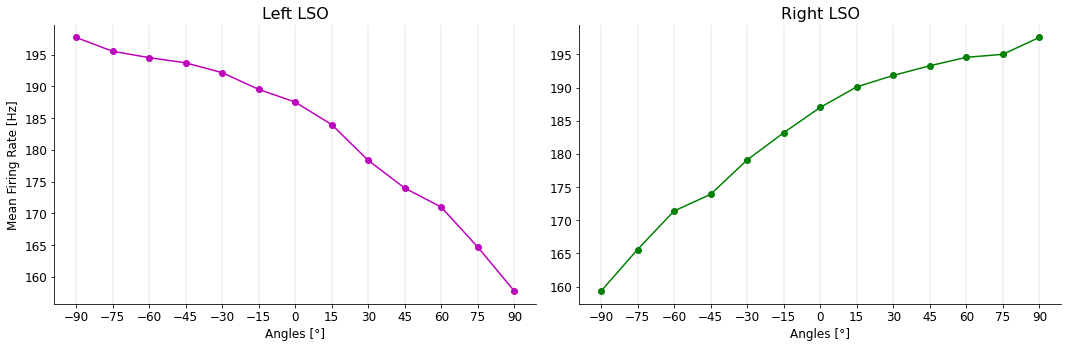

In [22]:
for tone in tones:

    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    path_r = folder_name + 'r_lso_results_tone_{}'.format(tone)
    path_l = folder_name + 'l_lso_results_tone_{}'.format(tone)
    
    ax[1].set_title("Right LSO")
    ax[0].set_title("Left LSO")

    ax[1].plot(angles,np.loadtxt(path_r), 'go-')
    ax[0].plot(angles,np.loadtxt(path_l),'mo-')

    for i in range(len(angles)):
        ax[0].axvline(angles[i], linewidth = 0.2, color = 'grey')
        ax[1].axvline(angles[i], linewidth = 0.2, color = 'grey')

    ax[0].set_xlabel("Angles [°]")
    ax[0].set_ylabel("Mean Firing Rate [Hz]")
    ax[0].set_xticks(angles)
    ax[0].spines['top'].set_visible(False) 
    ax[0].spines['right'].set_visible(False)

    ax[1].set_xlabel("Angles [°]")

    ax[1].set_xticks(angles)
    ax[1].spines['top'].set_visible(False) 
    ax[1].spines['right'].set_visible(False)
    fig.tight_layout()

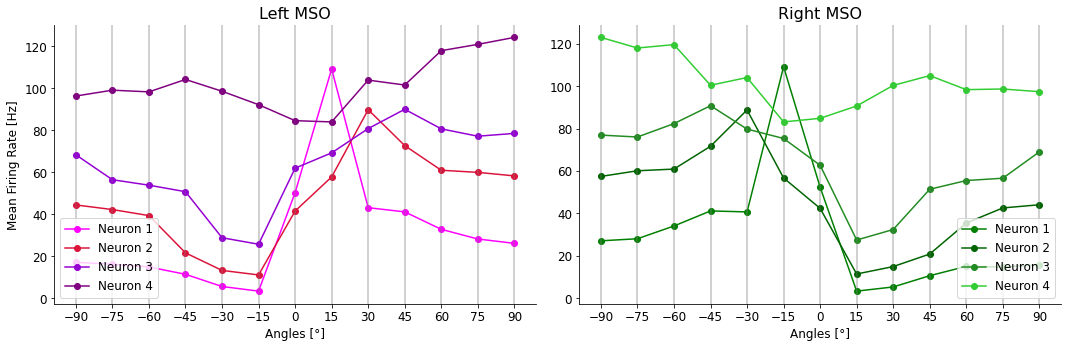

In [23]:
for tone in tones:

    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    for mso_neuron_id in mso_neurons:

        path_r = folder_name + 'r_mso_results_tone_{}'.format(tone) + '_neuron_{}'.format(mso_neuron_id)
        path_l = folder_name + 'l_mso_results_tone_{}'.format(tone) + '_neuron_{}'.format(mso_neuron_id)

        ax[1].set_title("Right MSO")
        ax[0].set_title("Left MSO")

        ax[1].plot(angles,np.loadtxt(path_r)[1], 'o-', color = colors_r[mso_neurons.index(mso_neuron_id)], label = "Neuron {}".format(mso_neuron_id))
        ax[0].plot(angles,np.loadtxt(path_l)[1],'o-', color = colors_l[mso_neurons.index(mso_neuron_id)], label = "Neuron {}".format(mso_neuron_id)) 

        for i in range(len(angles)):
            ax[0].axvline(angles[i], linewidth = 0.2, color = 'grey')
            ax[1].axvline(angles[i], linewidth = 0.2, color = 'grey')

        ax[0].set_xlabel("Angles [°]")
        ax[0].set_ylabel("Mean Firing Rate [Hz]")
        ax[0].set_xticks(angles)
        ax[0].legend(loc = 'lower left')
        ax[0].spines['top'].set_visible(False) 
        ax[0].spines['right'].set_visible(False)

        ax[1].set_xlabel("Angles [°]")
        ax[1].set_xticks(angles)
        ax[1].legend(loc = 'lower right')
        ax[1].spines['top'].set_visible(False) 
        ax[1].spines['right'].set_visible(False)
        
        fig.tight_layout()

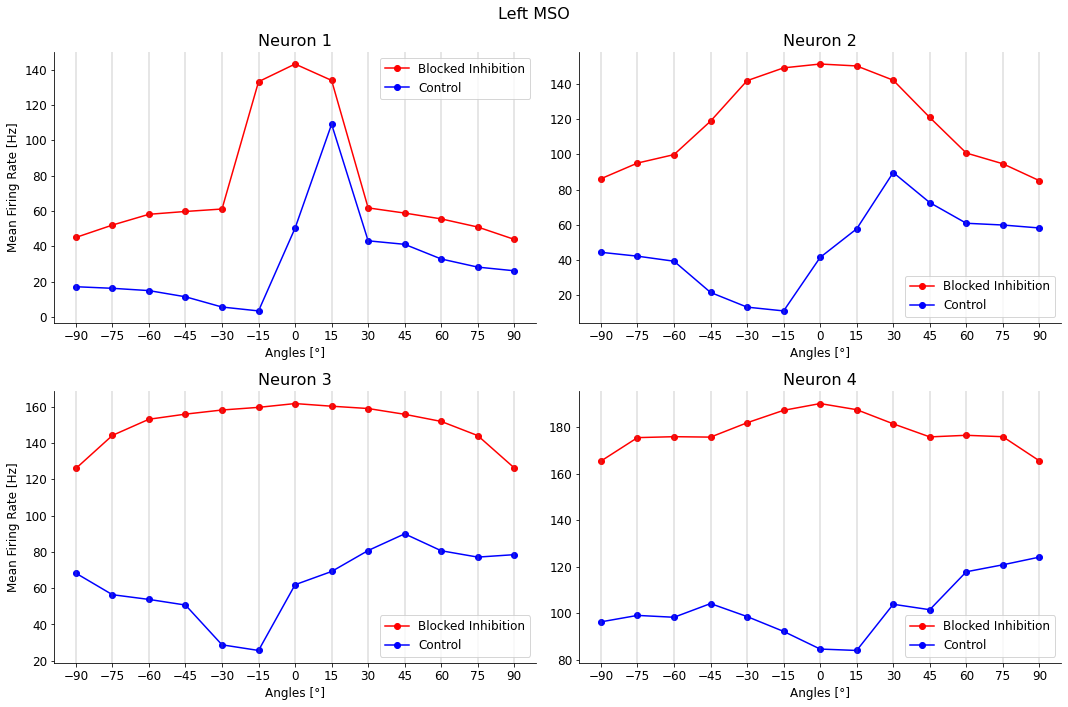

In [25]:
for tone in tones:

    fig, ax = plt.subplots(2, 2, figsize=(15,10))
    ax[0, 0].set_ylabel("Mean Firing Rate [Hz]")
    ax[1, 0].set_ylabel("Mean Firing Rate [Hz]")
    for mso_neuron_id in mso_neurons:

        path_l = folder_name + 'l_mso_results_tone_{}'.format(tone) + '_neuron_{}'.format(mso_neuron_id)
        fig.suptitle("Left MSO")

        ax[int(mso_neurons.index(mso_neuron_id)/2), mso_neurons.index(mso_neuron_id)%2].plot(angles,np.loadtxt(path_l)[0],"ro-", label = "Blocked Inhibition")
        ax[int(mso_neurons.index(mso_neuron_id)/2), mso_neurons.index(mso_neuron_id)%2].plot(angles,np.loadtxt(path_l)[1],"bo-", label = "Control")

        ax[int(mso_neurons.index(mso_neuron_id)/2), mso_neurons.index(mso_neuron_id)%2].set_title("Neuron {}".format(mso_neuron_id))
        
        for i in range(len(angles)):
            ax[int(mso_neurons.index(mso_neuron_id)/2), mso_neurons.index(mso_neuron_id)%2].axvline(angles[i], linewidth = 0.2, color = 'grey')
            ax[int(mso_neurons.index(mso_neuron_id)/2), mso_neurons.index(mso_neuron_id)%2].axvline(angles[i], linewidth = 0.2, color = 'grey')

        ax[int(mso_neurons.index(mso_neuron_id)/2), mso_neurons.index(mso_neuron_id)%2].set_xlabel("Angles [°]")
        ax[int(mso_neurons.index(mso_neuron_id)/2), mso_neurons.index(mso_neuron_id)%2].set_xticks(angles)
        ax[int(mso_neurons.index(mso_neuron_id)/2), mso_neurons.index(mso_neuron_id)%2].legend()
        ax[int(mso_neurons.index(mso_neuron_id)/2), mso_neurons.index(mso_neuron_id)%2].spines['top'].set_visible(False) 
        ax[int(mso_neurons.index(mso_neuron_id)/2), mso_neurons.index(mso_neuron_id)%2].spines['right'].set_visible(False)
        
        fig.tight_layout()